In [92]:
import pandas as pd
import networkx as nx
import numpy as np
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from copy import deepcopy
from scipy.integrate import solve_ivp
from itertools import combinations_with_replacement
from emn_model import (
    get_clean_dataset, generate_bipartite_network, diffusion_dynamics, tree_project_network
)

TEX_PLOTS = True

# Plotting config
if TEX_PLOTS:
    plt.rc("text", usetex=True)
    plt.rc("font", family="serif")
    plt.rc("text.latex", preamble=r"""
         \usepackage{times}
         \usepackage{mathptmx}
         \usepackage{siunitx}""")
else:
    plt.rc("text", usetex=False)

mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["font.size"] = 14
mpl.rcParams["axes.labelsize"] = mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.2
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["lines.linewidth"] = 1

cmap = mpl.cm.get_cmap("Dark2")
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=cmap.colors)

np.random.seed(1231)

In [2]:
df = get_clean_dataset()

In [3]:
B = generate_bipartite_network(df)

Trees: 55, genets: 24


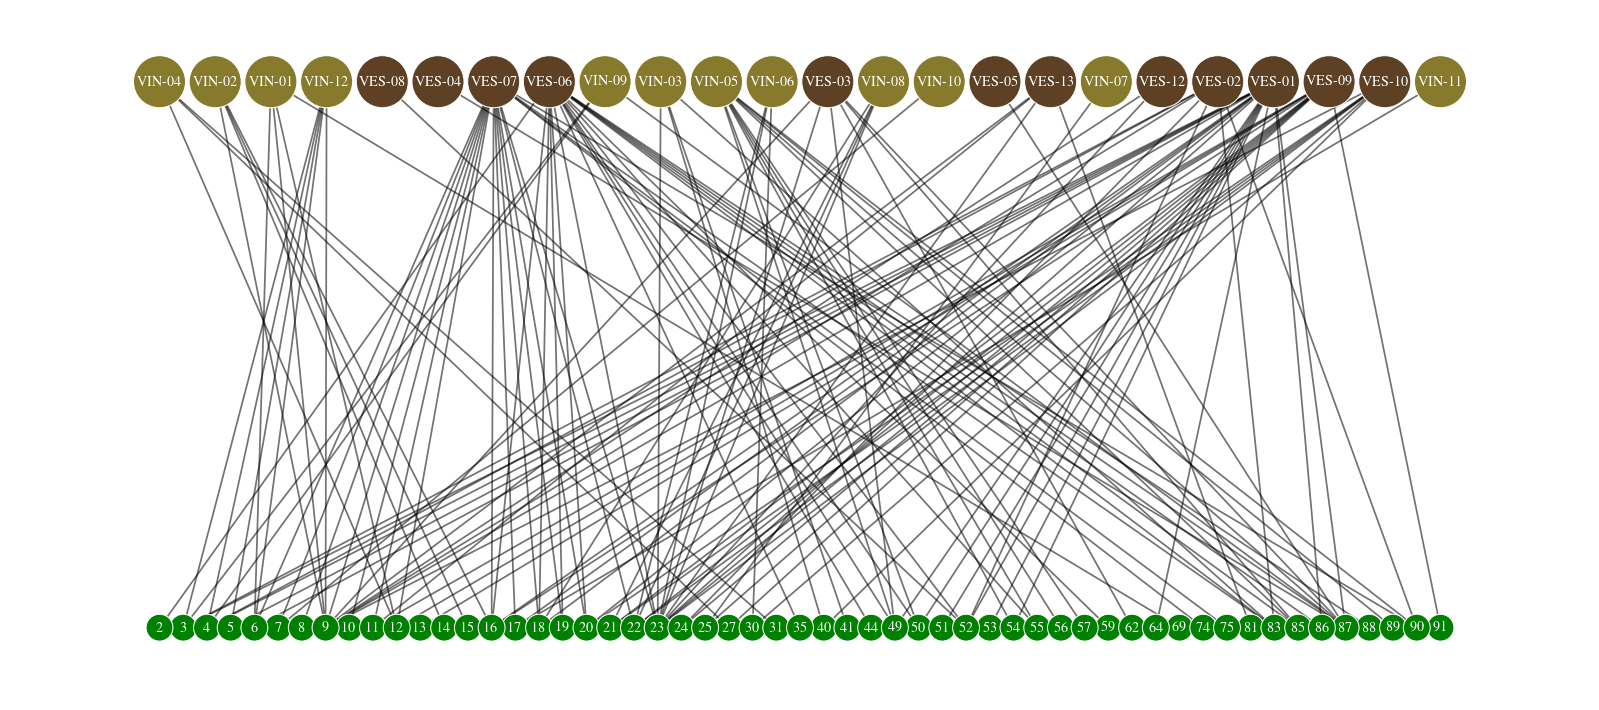

In [4]:
fungi, trees = bipartite.sets(B)
print(f"Trees: {len(trees)}, genets: {len(fungi)}")
pos = nx.bipartite_layout(B, trees, align="horizontal")

node_sizes = []
node_colors = []
for node in B.nodes:
    if B.nodes[node]["bipartite"] == 1:
        node_sizes.append(60)
        node_colors.append("green")
    else:
        node_sizes.append(225)
        if node[0:3] == "VES":
            node_colors.append("#5e4125")
        else:
            node_colors.append("#877a2d")

plt.figure(figsize=(8, 3.5), dpi=250, facecolor="w", frameon=False)
nx.draw_networkx_nodes(B, pos=pos, node_size=node_sizes, node_color=node_colors, linewidths=0.3, edgecolors="white")
nx.draw_networkx_labels(B, pos, font_color="white", font_size=4.15)
nx.draw_networkx_edges(B, pos, alpha=0.55, width=[0.5 for _ in range(len(B.nodes))])
plt.gca().set_axis_off()
plt.show()

In [5]:
def visualize_carbon_network(G, pos=None):
    if not pos:
        pos = nx.spring_layout(G, k=3, seed=99192, weight=None)
        
    node_sizes = []

    for node in G.nodes:
        node_size = max(10, G.nodes[node]["diameter"]*6)
        node_sizes.append(node_size)
        
    degrees_dict = {n: d for n, d in G.degree()}
    degrees = list(degrees_dict.values())
    carbon_values = list(nx.get_node_attributes(G, "carbon_value").values())
    sorted_degrees = sorted(degrees_dict, key=degrees_dict.get)

    plt.figure(figsize=(5, 4), dpi=250, facecolor="w", frameon=False)
    nx.draw_networkx_nodes(G, pos=pos, node_size=node_sizes, node_color=carbon_values,
                           edgecolors="black", linewidths=0.3, cmap=mpl.cm.coolwarm)
    #nx.draw_networkx_labels(G, pos, labels = nx.get_node_attributes(G, "carbon_value"), font_color="black", font_size=4.1)
    nx.draw_networkx_edges(G, pos, alpha=0.4, width=[0.2 for _ in range(len(G.nodes))])
    plt.gca().set_axis_off()
    plt.show()

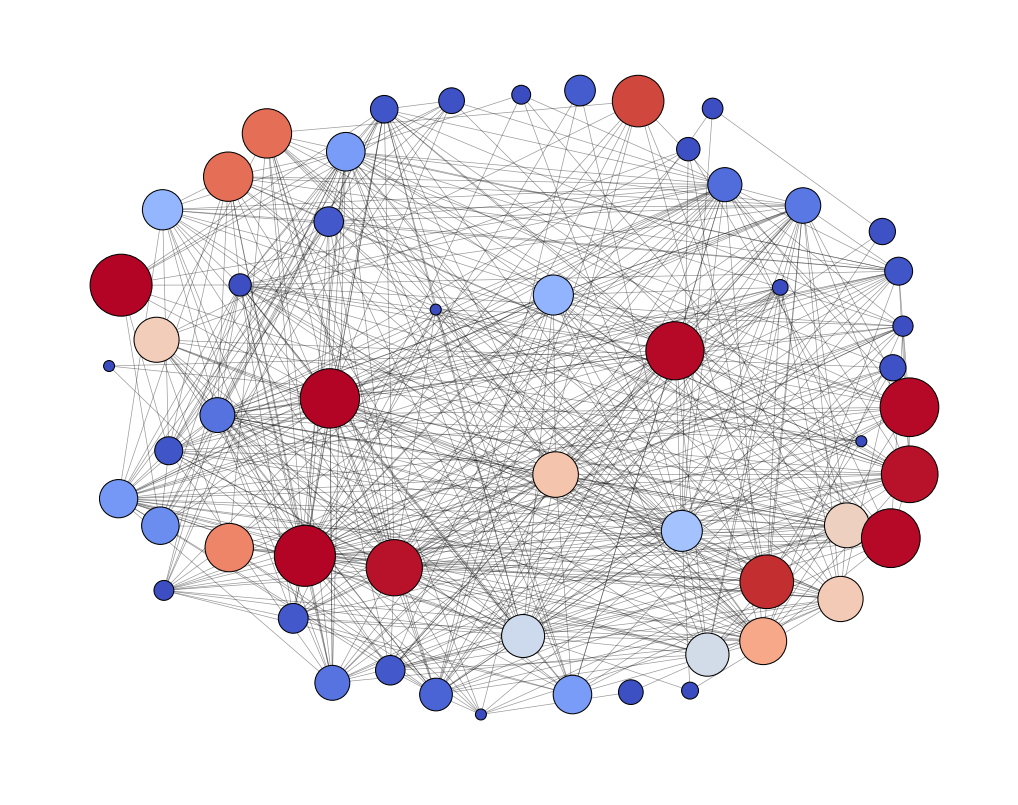

In [6]:
G = tree_project_network(B)
pos = nx.spring_layout(G, k=3, seed=99192, weight=None)
visualize_carbon_network(G, pos)

In [7]:
diameters = list(nx.get_node_attributes(G, "diameter").values())
np.min(diameters), np.max(diameters)

(0.5618793160886497, 53.058672055548946)

In [83]:
N = len(G.nodes)

plant_carbon_0 = np.array(list(nx.get_node_attributes(G, "carbon_value").values()))
root_carbon_0 = 0.1 * plant_carbon_0
plant_diameter_0 = np.array(list(nx.get_node_attributes(G, "diameter").values()))

t_range = (0, 16_000)
D_C = 5.0e-4 # carbon diffusion coeff
uptake_ps = (0.55, 0.0, 55.0)
f = 5.0e-4 # sensitive w.r.t plant carbon deposition
k = 0.6
g = 0.004
c = 0.82
rho = 0.01

sol = solve_ivp(diffusion_dynamics, t_range, np.concatenate([root_carbon_0, plant_carbon_0, plant_diameter_0]),
                args=(G, D_C, N, uptake_ps, f, k, c, g, rho), dense_output=True, method="BDF")

time_steps = 300
t = np.linspace(t_range[0], t_range[1], time_steps)
z = sol.sol(t)

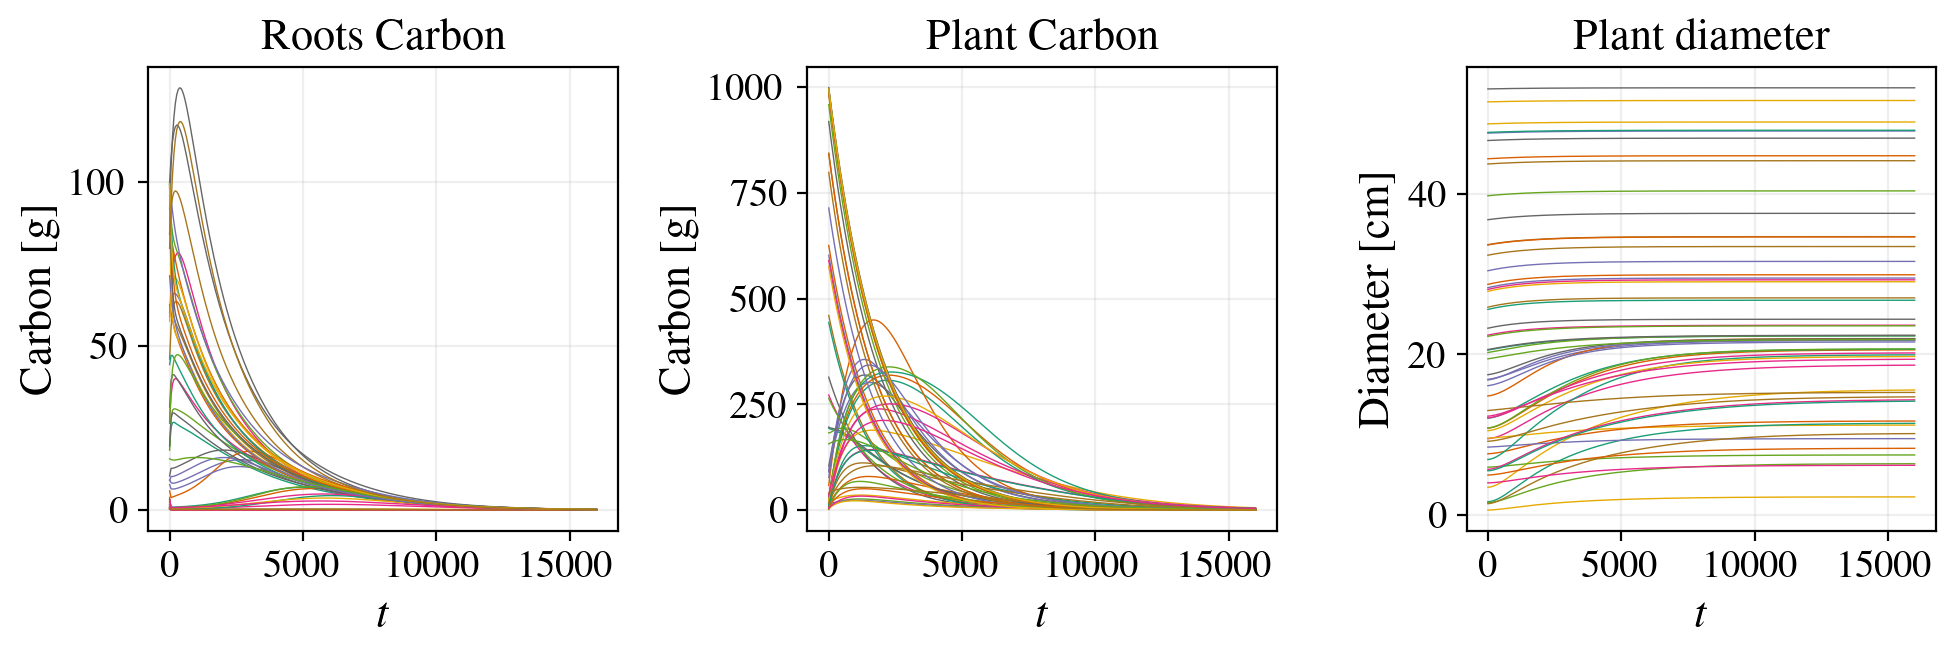

In [84]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), dpi=200)

axes[0].set_title("Roots Carbon")
for i in range(N):
    axes[0].plot(t, z[i], linewidth=0.5)
    axes[0].set_ylabel("Carbon [g]")
    
axes[1].set_title("Plant Carbon")
for i in range(N, 2*N):
    axes[1].plot(t, z[i], linewidth=0.5)
    axes[1].set_ylabel("Carbon [g]")
    
axes[2].set_title("Plant diameter")
for i in range(2*N, 3*N):
    axes[2].plot(t, z[i], linewidth=0.5)
    axes[2].set_ylabel("Diameter [cm]")
    #axes[2].set_yscale("log")
    
for ax in axes:
    ax.set_xlabel("$t$")

plt.tight_layout()
plt.show()

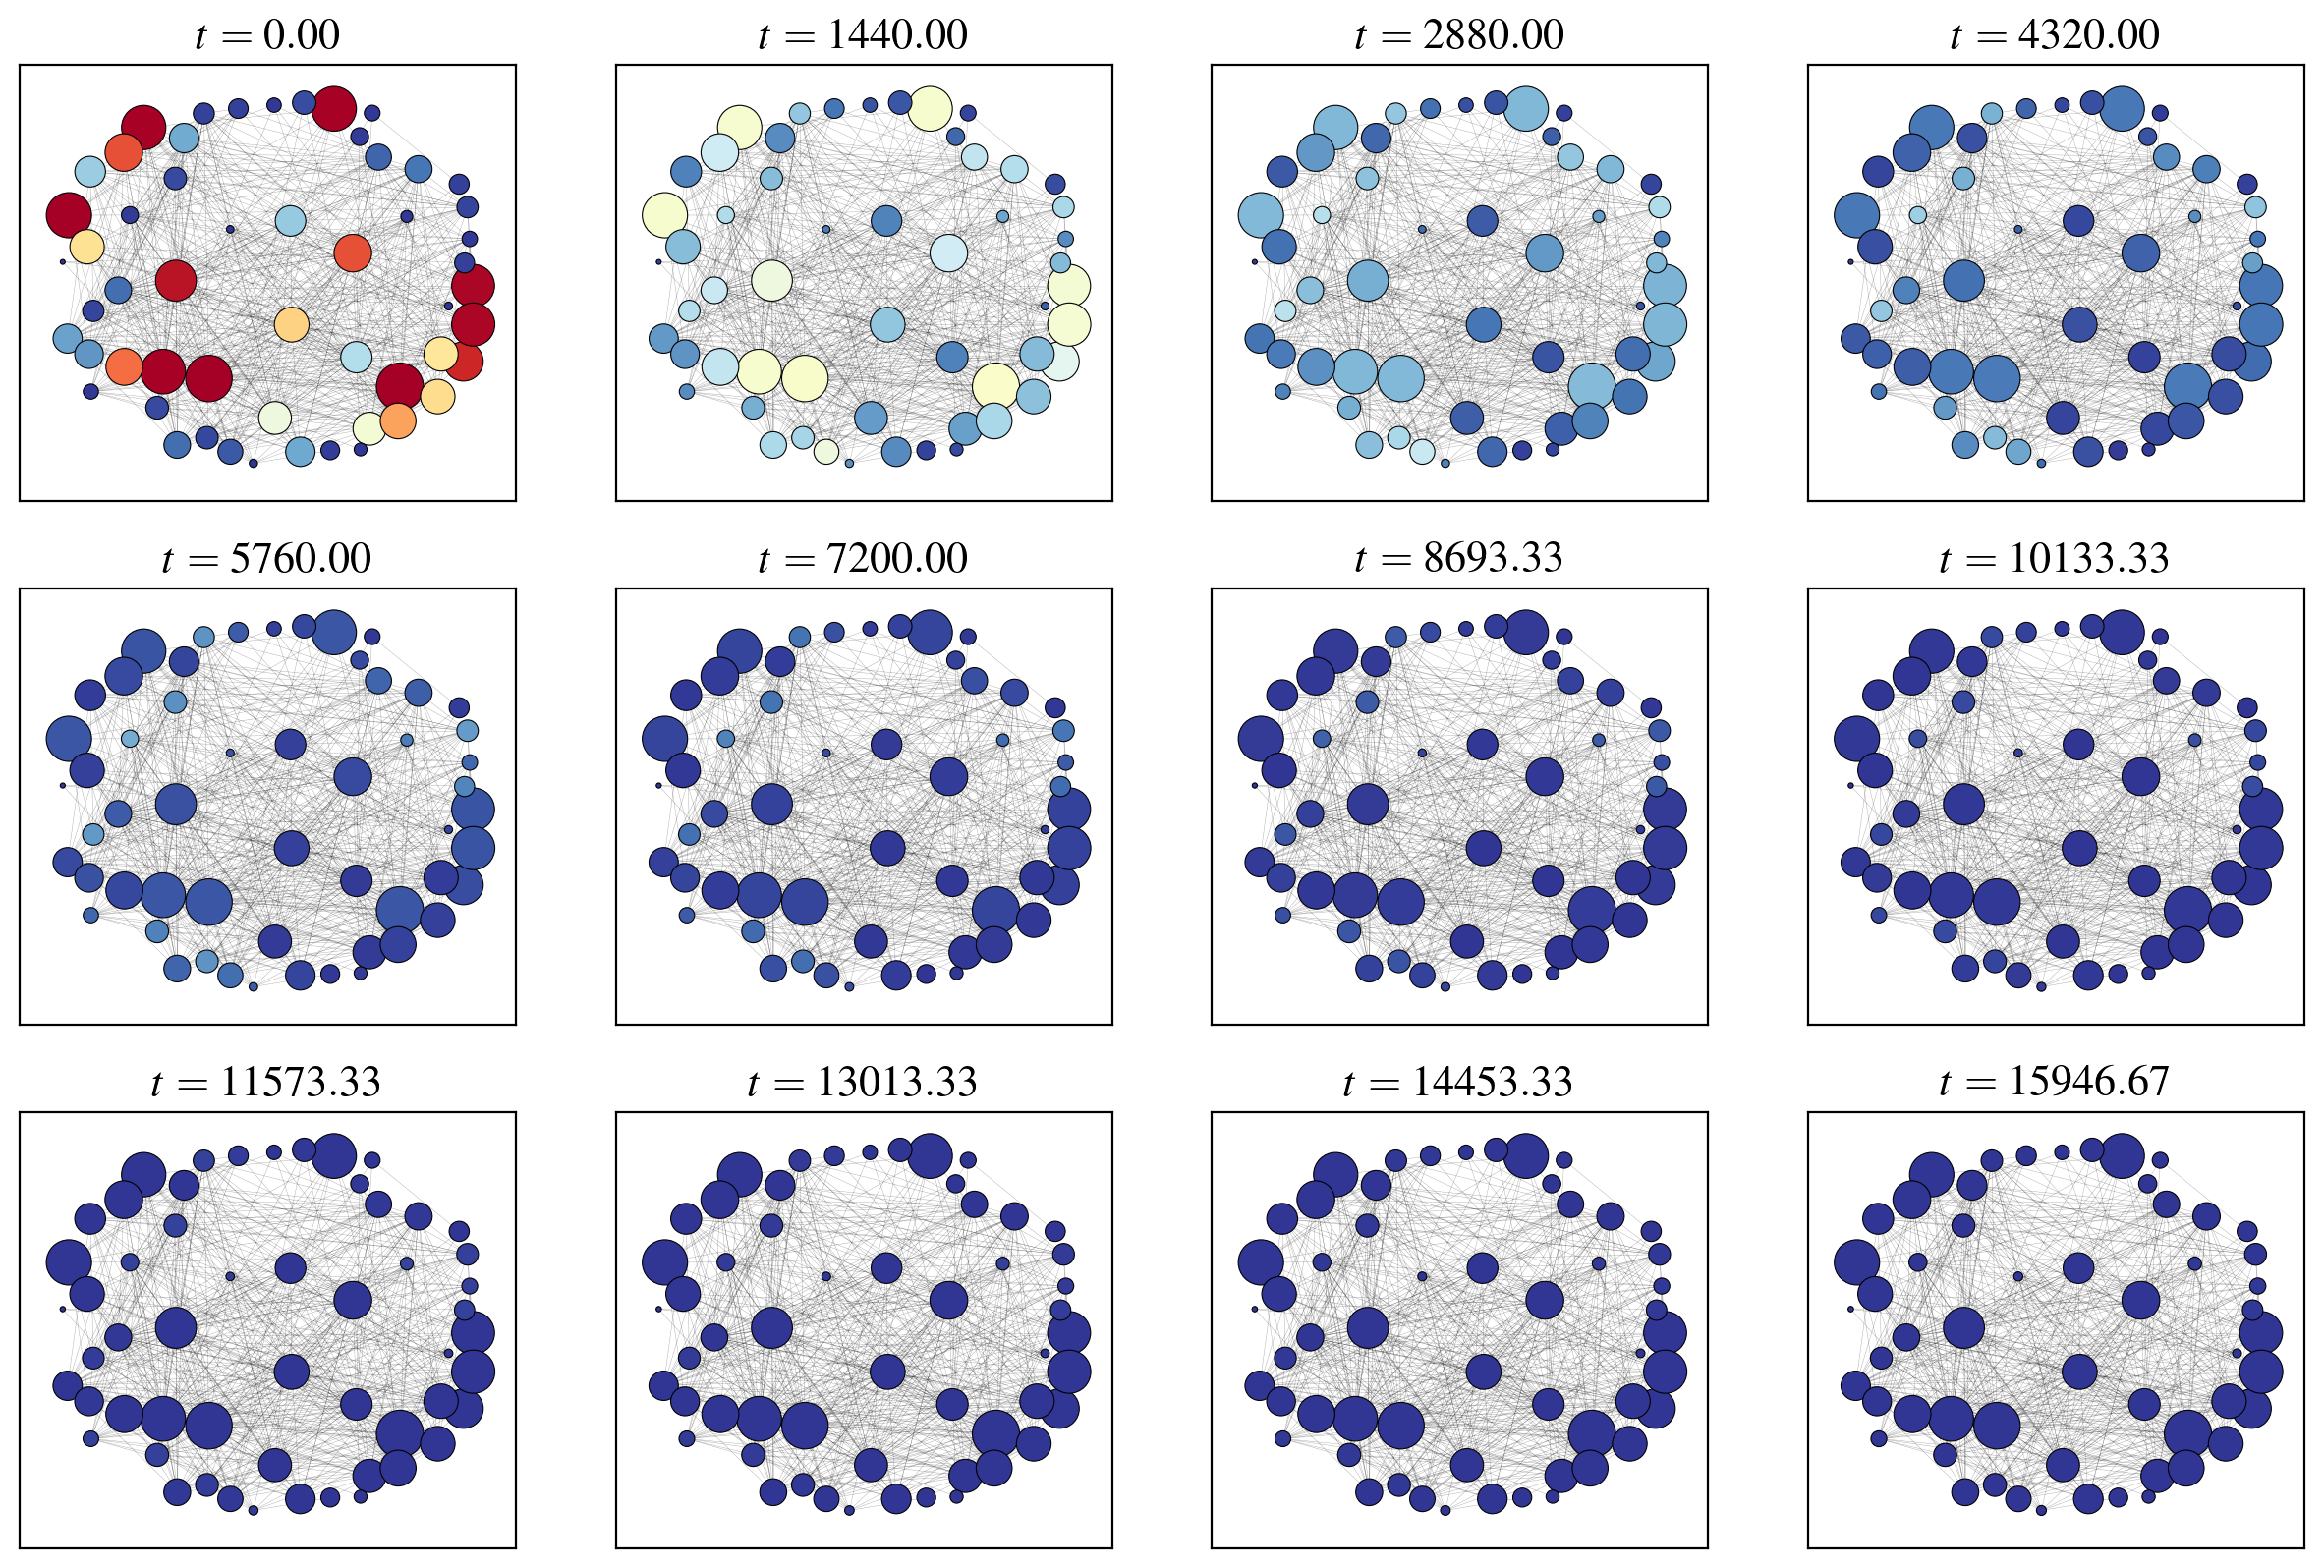

In [85]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

steps = np.linspace(0, time_steps-1, 12, dtype=int)

plant_carbon_data = z[N:2*N,:]
min_carbon, max_carbon = np.min(plant_carbon_data), np.max(plant_carbon_data)

diameter_data = z[2*N:,:]
max_diameter = np.max(diameter_data)

nodes_by_cohort = {1: [], 2: [], 3: [], 4: []}
node_list = list(G.nodes)

for node in G.nodes:
    nodes_by_cohort[G.nodes[node]["cohort"]].append(node)

for j, ax in enumerate(axes.flat):
    ax.set_title(f"$t = {(steps[j])*t_range[1]/time_steps:.2f}$")
    ax.grid(False)
    
    roots_carbon_vals_t = z[:,steps[j]][:N]
    plant_carbon_vals_t = z[:,steps[j]][N:2*N]
    diameter_vals_t = (z[:,j][2*N:3*N])/max_diameter*300
#     diameter_vals_log = np.log(1+diameter_vals_t)*50
    
    edges = nx.draw_networkx_edges(G, pos, alpha=0.35, width=[0.15 for _ in range(len(G.nodes))], ax=ax)
    edges.set_zorder(-1)
    
    # set correct z-index for nodes so small nodes don't get hidden behind big nodes. hacky but works :)
    for cohort, nodes in nodes_by_cohort.items():
        H = G.subgraph(nodes)
        node_idxs = [node_list.index(node) for node in nodes]
        collection = nx.draw_networkx_nodes(
            H, pos=pos, node_size=diameter_vals_t[node_idxs], node_color=plant_carbon_vals_t[node_idxs],
            edgecolors="black", linewidths=0.4, cmap=mpl.cm.RdYlBu_r, ax=ax, vmin=min_carbon, vmax=max_carbon)
        collection.set_zorder(4-cohort)
    
plt.show()

In [109]:
def max_growth_diff(percentages):
    perms = itertools.permutations(percentages, 2)
    diffs = np.array([np.abs(a - b) for a, b in perms])

    return np.max(diffs)

Cohort 1 grew on average 4.840706548064832 cm
Cohort 1 grew on average 423.38503817235454% +- 0.0


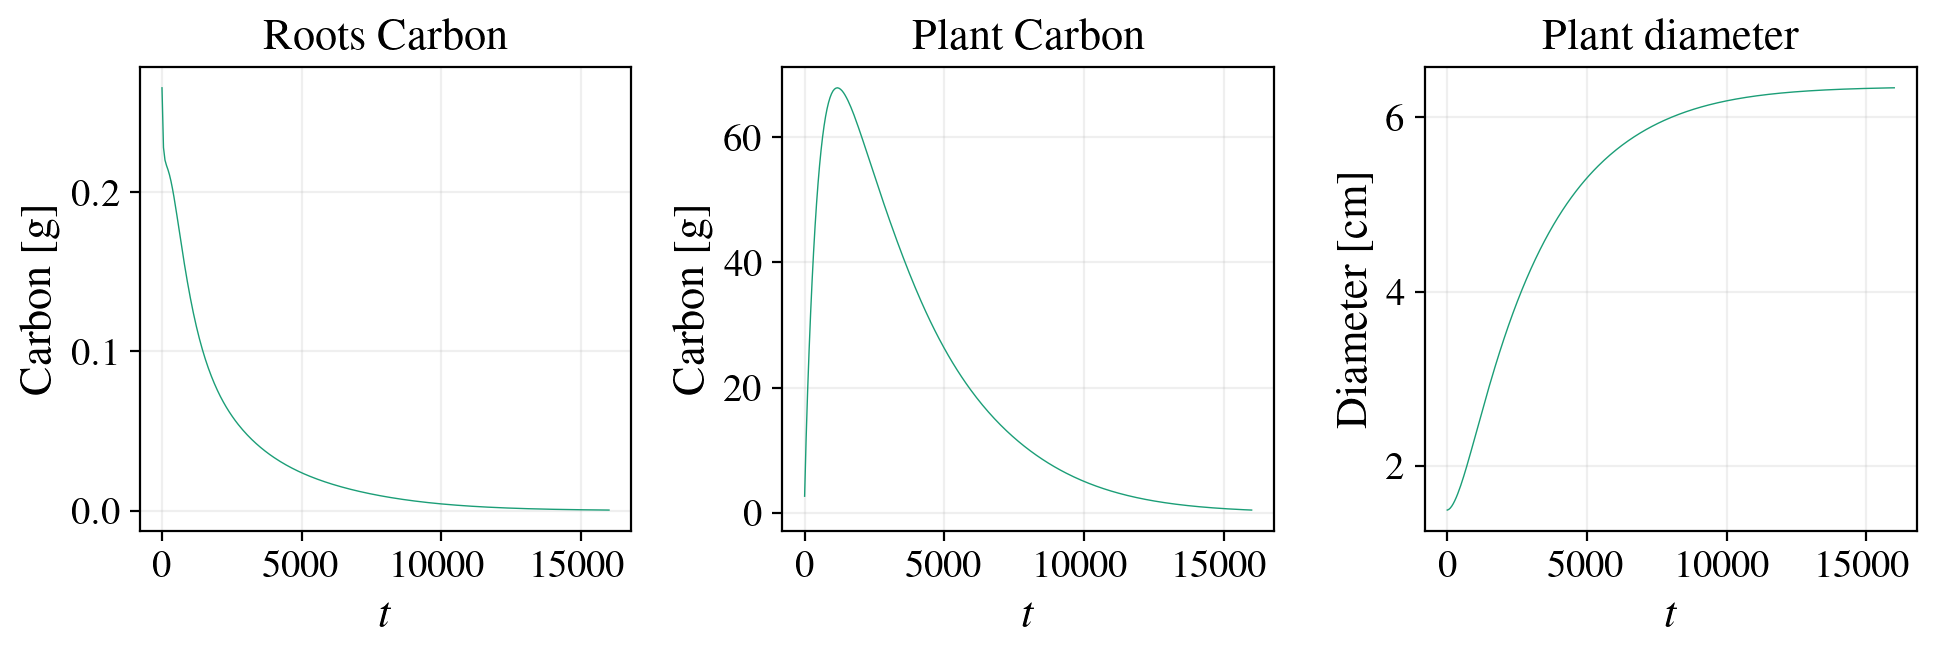

Cohort 2 grew on average 6.5871380294527775 cm
Cohort 2 grew on average 239.65093834117707% +- 167.78116445200908
Cohort 2 max growth difference (competition) 628.5246279229016%


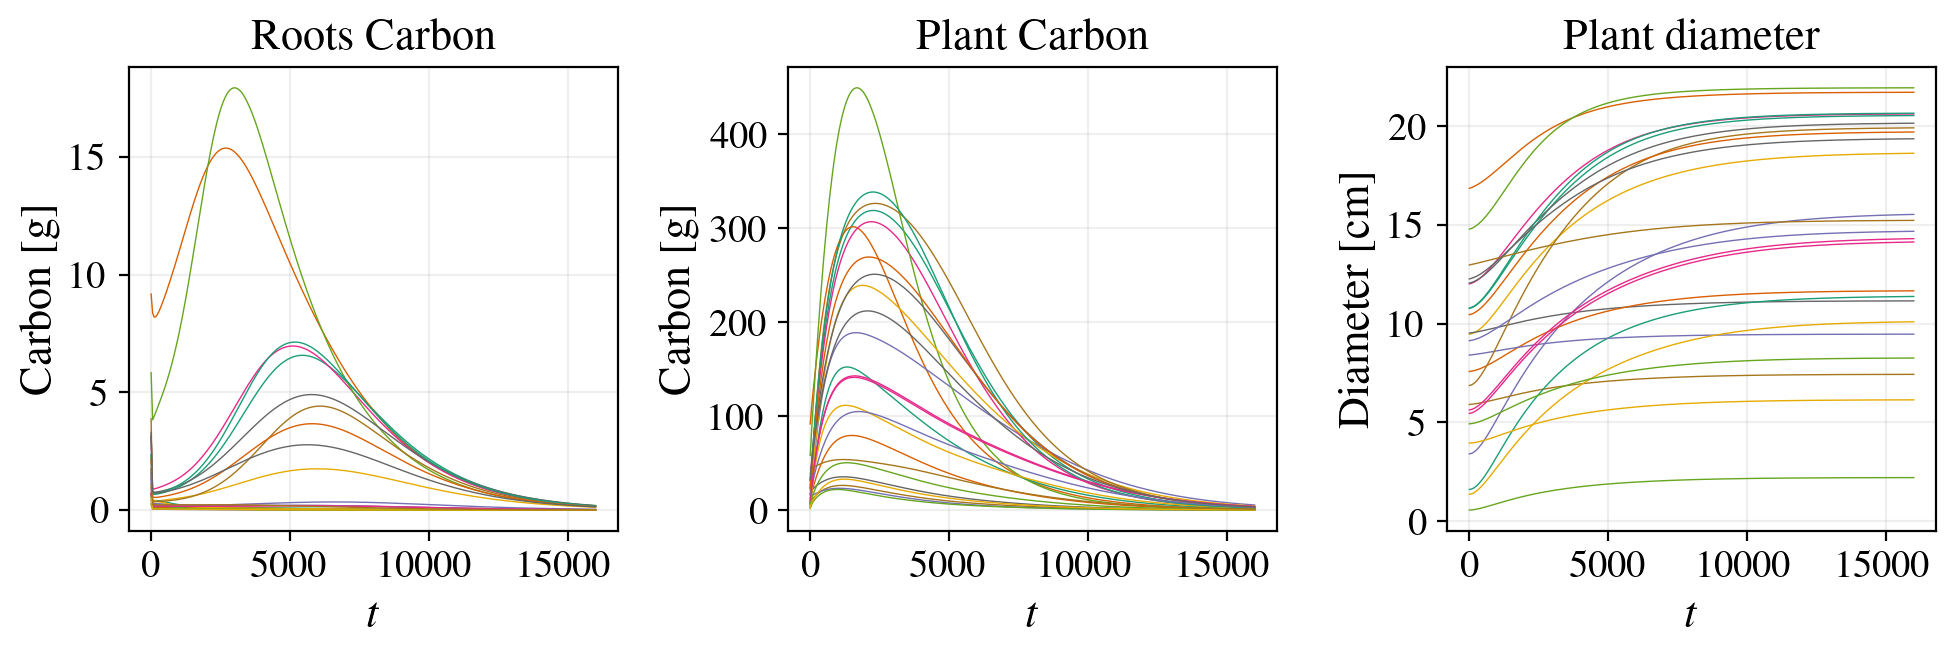

Cohort 3 grew on average 1.945481094516765 cm
Cohort 3 grew on average 109.55946178064603% +- 9.163641552084536
Cohort 3 max growth difference (competition) 30.946003865016564%


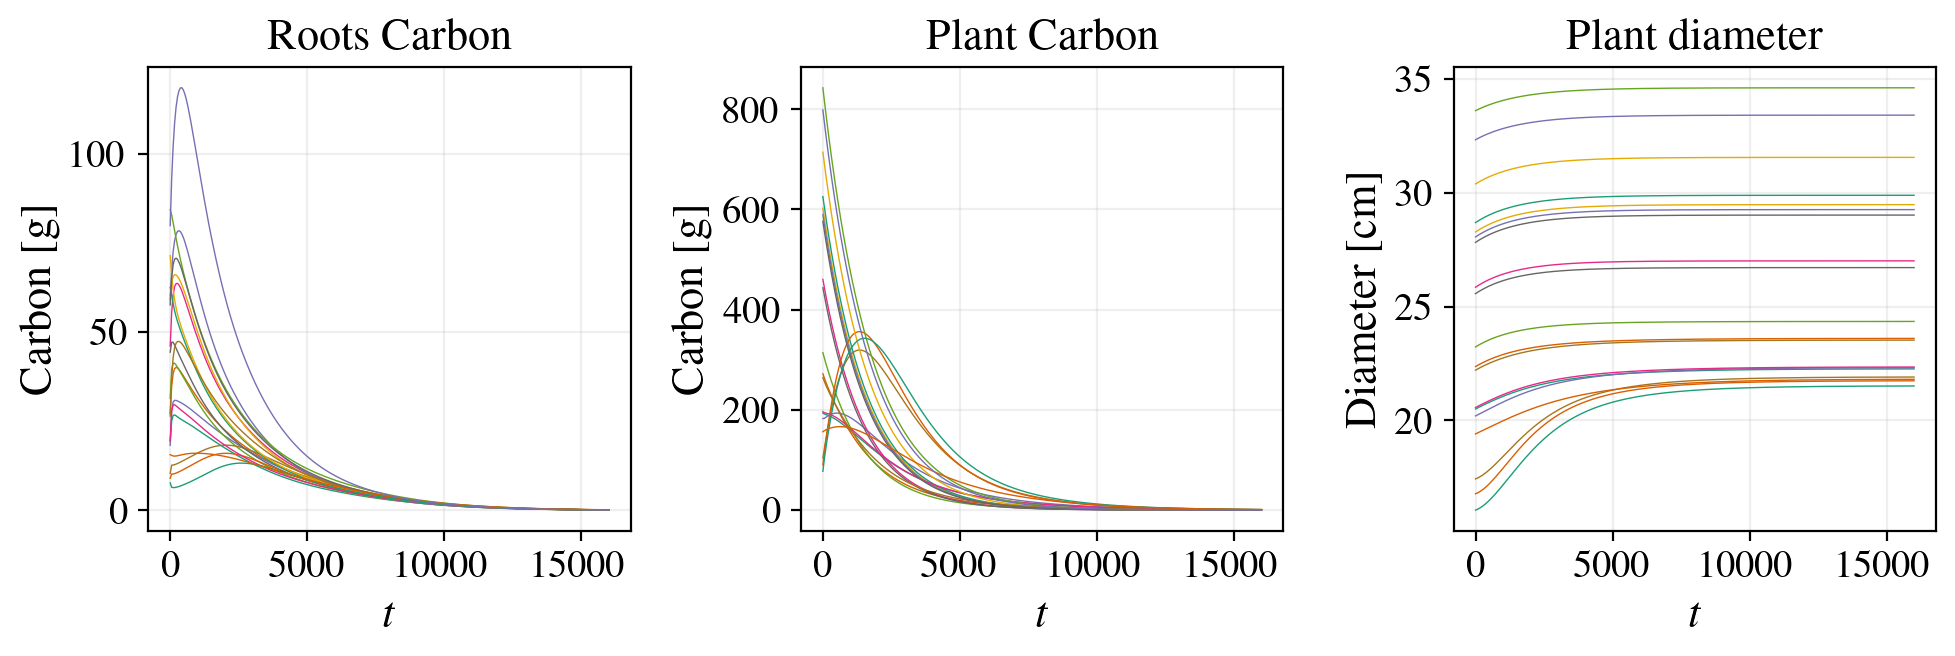

Cohort 4 grew on average 0.4124779768315243 cm
Cohort 4 grew on average 101.02062496022444% +- 0.818523205958547
Cohort 4 max growth difference (competition) 2.713670947197201%


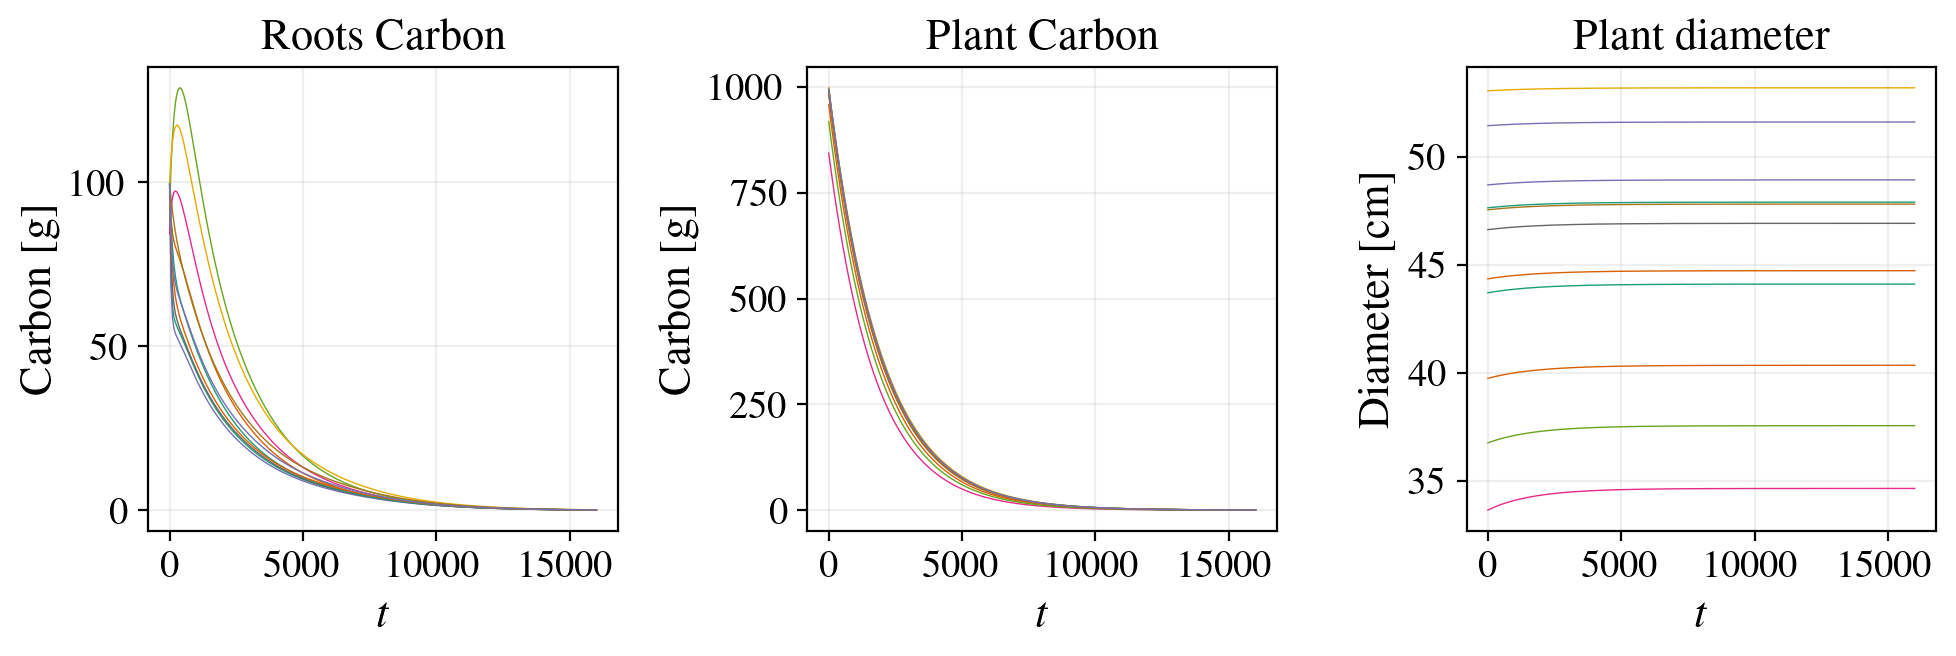

In [112]:
for cohort, nodes in nodes_by_cohort.items():
    node_idxs = [node_list.index(node) for node in nodes]
    growth = diameter_data[node_idxs, -1] - diameter_data[node_idxs, 0]
    avg_growth = np.mean(growth)
    percentages = diameter_data[node_idxs, -1]/diameter_data[node_idxs, 0]*100
    percentage_mean = np.mean(percentages)
    percentage_stdev = np.std(percentages)

    print(f"Cohort {str(cohort)} grew on average {avg_growth} cm")
    print(f"Cohort {str(cohort)} grew on average {percentage_mean}% +- {percentage_stdev}")
    
    if cohort != 1:
        growth_diff = max_growth_diff(percentages)
        print(f"Cohort {str(cohort)} max growth difference (competition) {growth_diff}%")
        
#     print(percentages)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), dpi=200)

    roots_carbon_data = z[:N,:]
    plant_carbon_data = z[N:2*N,:]

    axes[0].set_title("Roots Carbon")
    axes[0].plot(t, roots_carbon_data[node_idxs, :].T, linewidth=0.5)
    axes[0].set_xlabel("$t$")
    axes[0].set_ylabel("Carbon [g]")

    axes[1].set_title("Plant Carbon")
    axes[1].plot(t, plant_carbon_data[node_idxs, :].T, linewidth=0.5)
    axes[1].set_xlabel("$t$")
    axes[1].set_ylabel("Carbon [g]")

    axes[2].set_title("Plant diameter")
    axes[2].plot(t, diameter_data[node_idxs, :].T, linewidth=0.5)
    axes[2].set_xlabel("$t$")
    axes[2].set_ylabel("Diameter [cm]")
    # axes[2].set_yscale("log")

    plt.tight_layout()
    plt.show()

In [70]:
def animate_frames(zs, folder):
    import gc
    
    for j in range(time_steps):
        filename = f"movie_frames/{folder}/{j:04}.png"
        fig, ax = plt.subplots(figsize=(5, 4), dpi=200)

        ax.set_title(f"$t = {j*t_range[1]/time_steps:.2f}$")
        roots_carbon_vals_t = zs[:,j][:N]
        plant_carbon_vals_t = zs[:,j][N:]
        nx.draw_networkx_nodes(G, pos=pos, node_size=node_sizes, node_color=plant_carbon_vals_t,
                           edgecolors="black", linewidths=0.3, cmap=mpl.cm.coolwarm, ax=ax, vmin=0, vmax=10)
        nx.draw_networkx_edges(G, pos, alpha=0.4, width=[0.2 for _ in range(len(G.nodes))], ax=ax)
        plt.tight_layout()
        plt.gca().set_axis_off()
        plt.savefig(filename, facecolor='white', transparent=False)

        # https://stackoverflow.com/questions/7101404/how-can-i-release-memory-after-creating-matplotlib-figures
        plt.clf()
        plt.close()
        gc.collect()
        
# animate_frames(z, "source_sink")